In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

plt.rcParams.update({"figure.figsize": (6, 6),
                      "axes.facecolor": "white",
                      "axes.edgecolor": "black"})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sb.color_palette('colorblind'))
font = {'family': 'sans-serif',
         'weight': 'normal',
         'size': 14}
plt.rc('font', **font)

file_path = 'Synthetic_ICU_Dataset_CGPT.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Patient_ID'])
df.head()

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10423 entries, 0 to 10422
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Admission Hospital         10423 non-null  object
 1   Admission Unit             10423 non-null  object
 2   Admission Date             10423 non-null  object
 3   Admission Decision Time    10423 non-null  object
 4   Admission Time             10423 non-null  object
 5   Discharge Date             10423 non-null  object
 6   Survived                   10423 non-null  int64 
 7   Diagnosis                  10423 non-null  object
 8   Length of Stay             10423 non-null  int64 
 9   Cardiovascular Support     10423 non-null  int64 
 10  Dialysis Support           10423 non-null  int64 
 11  Invasive Ventilation       10423 non-null  int64 
 12  Nutrition                  10423 non-null  int64 
 13  Age                        10423 non-null  int64 
 14  Gender

In [2]:
categorical_columns = ['Admission Hospital', 'Admission Unit', 'Diagnosis', 'Gender']
for column in categorical_columns:
    df[column] = df[column].astype('category')

category_names = {col: df[col].cat.categories for col in categorical_columns}

df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
# df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(df.head())

  Admission Date Admission Decision Time Admission Time Discharge Date  \
0     2022-07-19                   10:11          12:11     02/08/2022   
1     2022-08-22                   07:48          09:48     24/08/2022   
2     2022-01-26                   16:50          17:50     05/02/2022   
3     2022-02-11                   19:09          22:09     15/02/2022   
4     2022-03-02                   00:23          02:23     06/03/2022   

   Survived  Length of Stay  Cardiovascular Support  Dialysis Support  \
0         0              14                       1                 0   
1         1               2                       0                 0   
2         0              10                       1                 0   
3         1               4                       0                 0   
4         1               4                       0                 0   

   Invasive Ventilation  Nutrition  ...  Diagnosis_Sepsis  \
0                     0          1  ...             Fal

In [3]:
from datetime import datetime, timedelta

df['Admission Date'] = pd.to_datetime(df['Admission Date'], format='%Y-%m-%d')
df['Admission Decision Time'] = pd.to_datetime(df['Admission Decision Time'], format='%H:%M').dt.time
df['Admission Time'] = pd.to_datetime(df['Admission Time'], format='%H:%M').dt.time
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], format='%d/%m/%Y')

def calculate_wait_time(row):
    decision_datetime = datetime.combine(row['Admission Date'], row['Admission Decision Time'])
    admission_datetime = datetime.combine(row['Admission Date'], row['Admission Time'])

    if admission_datetime < decision_datetime:
        admission_datetime += timedelta(days=1)

    return (admission_datetime - decision_datetime).total_seconds() / 3600

df['Wait Time (hrs)'] = df.apply(calculate_wait_time, axis=1)

df['Month'] = df['Admission Date'].dt.month
season_mapping = {
    11: 'Winter', 12: 'Winter', 1: 'Winter',
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn'
}

df['Season'] = df['Month'].map(season_mapping)

df.to_csv('Synthetic_ICU_Dataset_CGPT2.csv', index=False)

print(df[['Admission Date', 'Month', 'Season', 'Wait Time (hrs)']].head())

  Admission Date  Month  Season  Wait Time (hrs)
0     2022-07-19      7  Summer              2.0
1     2022-08-22      8  Autumn              2.0
2     2022-01-26      1  Winter              1.0
3     2022-02-11      2  Spring              3.0
4     2022-03-02      3  Spring              2.0


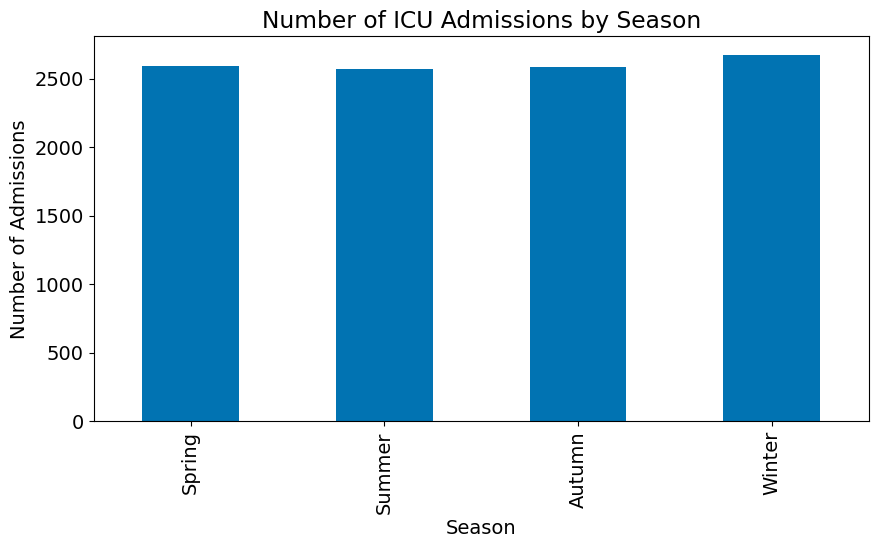

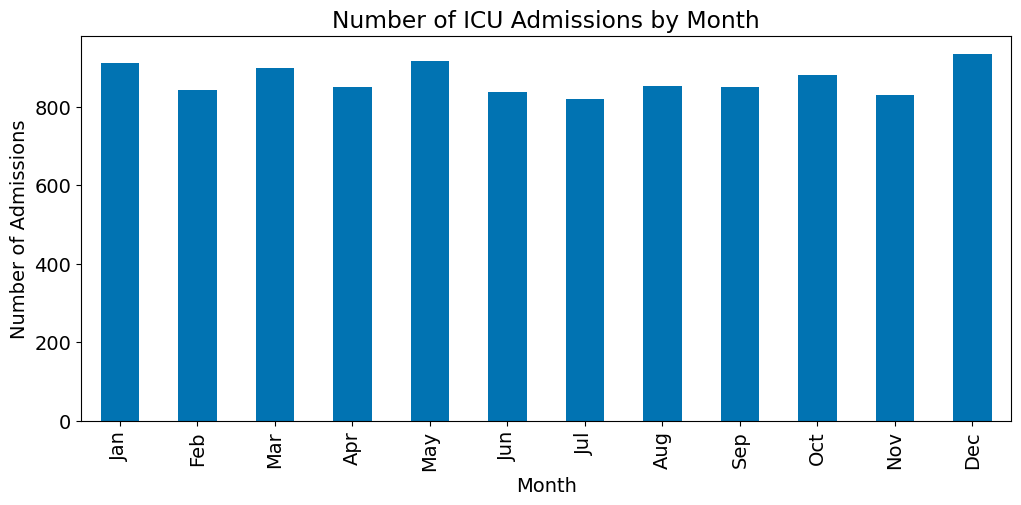

In [4]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df['Season'] = pd.Categorical(df['Season'], categories=season_order, ordered=True)
season_tally = df['Season'].value_counts().reindex(season_order)

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['Month Name'] = df['Month'].map(month_mapping)  
df['Month Name'] = pd.Categorical(df['Month Name'], categories=month_order, ordered=True)
month_tally = df['Month Name'].value_counts().reindex(month_order)

plt.figure(figsize=(10, 5))
season_tally.plot(kind='bar')
plt.title('Number of ICU Admissions by Season')
plt.xlabel('Season')
plt.ylabel('Number of Admissions')
plt.grid(False)
plt.show()

plt.figure(figsize=(12, 5))
month_tally.plot(kind='bar')
plt.title('Number of ICU Admissions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Admissions')
plt.grid(False)
plt.show()

In [5]:
from pycaret.time_series import *

df = df.sort_values(by='Admission Date')

df.set_index('Admission Date', inplace=True)

df_daily = df.resample('D').size() 


df_daily = df_daily.to_frame(name='ICU_Admissions')
print(df_daily.head()) 
print(df_daily.tail()) 
print(df_daily.columns) 

train = df_daily[:-70]
test = df_daily[-70:]

ts_setup = setup(
    # data=df_daily,
    data=train,
    target='ICU_Admissions', 
    fold_strategy='expanding',
    session_id=123,
    # seasonal_period=365, 
    transform_target=None
)

print(ts_setup)

best_model = compare_models()
print(f"Best model: {best_model}")

future_predictions = predict_model(best_model, fh=100)
print(future_predictions)
# best_model = create_model('arima', seasonal='mul', sp=7)	

                ICU_Admissions
Admission Date                
2022-01-01                  27
2022-01-02                  22
2022-01-03                  28
2022-01-04                  26
2022-01-05                  28
                ICU_Admissions
Admission Date                
2022-12-27                  26
2022-12-28                  30
2022-12-29                  27
2022-12-30                  29
2022-12-31                  36
Index(['ICU_Admissions'], dtype='object')


,Description,Value
0,session_id,123
1,Target,ICU_Admissions
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(295, 1)"
5,Transformed data shape,"(295, 1)"
6,Transformed train set shape,"(294, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.1010,0.8759,5.5427,5.5427,0.1550,0.1734,0.1867
grand_means,Grand Means Forecaster,1.2361,0.9834,6.2226,6.2226,0.1714,0.1921,3.0333
snaive,Seasonal Naive Forecaster,1.3243,1.0535,6.6667,6.6667,0.1844,0.2061,2.7900
arima,ARIMA,1.3549,1.0779,6.8206,6.8206,0.1884,0.2116,0.3133
croston,Croston,1.3640,1.0851,6.8664,6.8664,0.1896,0.2148,0.0367
polytrend,Polynomial Trend Forecaster,1.4808,1.1781,7.4552,7.4552,0.2073,0.2357,0.0333
naive,Naive Forecaster,1.6546,1.3165,8.3333,8.3333,0.2399,0.2557,3.6133
theta,Theta Forecaster,1.7165,1.3655,8.6395,8.6395,0.2351,0.2814,4.0033
ets,ETS,1.7250,1.3723,8.6823,8.6823,0.2352,0.2842,0.4467
exp_smooth,Exponential Smoothing,1.7251,1.3723,8.6826,8.6826,0.2352,0.2843,0.4600


Best model: BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [34, 33,
                                                                        32, 31,
                                                                        30, 29,
                                                                        28, 27,
                                                                        26, 25,
                                                                        24, 23,
                                                                        22, 21,
                                                                        20, 19,
                                                                        18, 17,
                                                                        16, 15,
                                                                        14, 13,
                                                                        12, 11,
                            

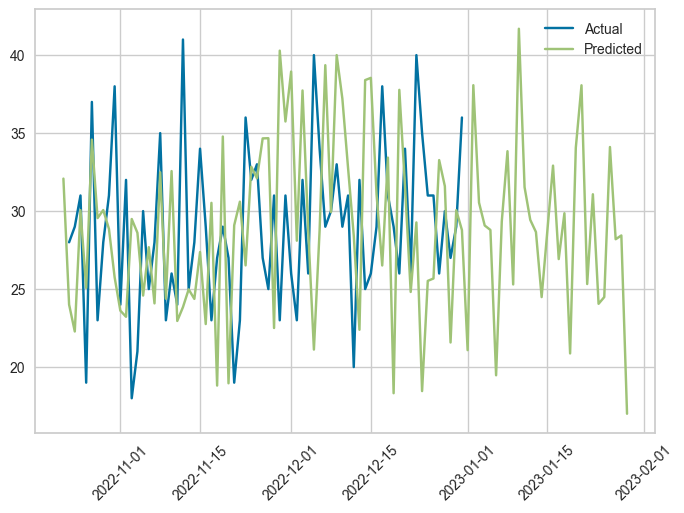

In [6]:
from sklearn.metrics import mean_absolute_error

y_pred = future_predictions['y_pred']  # Predicted values
y_true = test['ICU_Admissions']      # Actual values from the test set

# mae = mean_absolute_error(y_true, y_pred[])
# print(f"Mean Absolute Error: {mae}")

# Optionally, plot the results
import matplotlib.pyplot as plt
plt.plot(test.index, y_true, label='Actual')
plt.plot(future_predictions.index, y_pred, label='Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(df_daily.index, df_daily['ICU_Admissions'], test_size=0.2, shuffle=True)

# print(best_model.get_params())
# best_model = AutoARIMA()
# best_model.set_params(sp=7, alpha=0.01, max_p=10, max_q=10, max_d=3, stepwise=False, random=True, n_fits=20)
# best_model.fit(y_train)

In [8]:
plot_model(best_model, plot='forecast')


# tuned_model = tune_model(best_model)
# print(tuned_model.get_params())
# future_predictions = predict_model(tuned_model, fh=30, return_pred_int=True)
future_predictions = predict_model(best_model, fh=100, return_pred_int=True)

print(future_predictions)


             y_pred  lower  upper
2022-10-22  32.0820    NaN    NaN
2022-10-23  24.0080    NaN    NaN
2022-10-24  22.2811    NaN    NaN
2022-10-25  30.0603    NaN    NaN
2022-10-26  25.0713    NaN    NaN
...             ...    ...    ...
2023-01-25  24.4882    NaN    NaN
2023-01-26  34.1089    NaN    NaN
2023-01-27  28.1966    NaN    NaN
2023-01-28  28.4376    NaN    NaN
2023-01-29  17.0071    NaN    NaN

[100 rows x 3 columns]


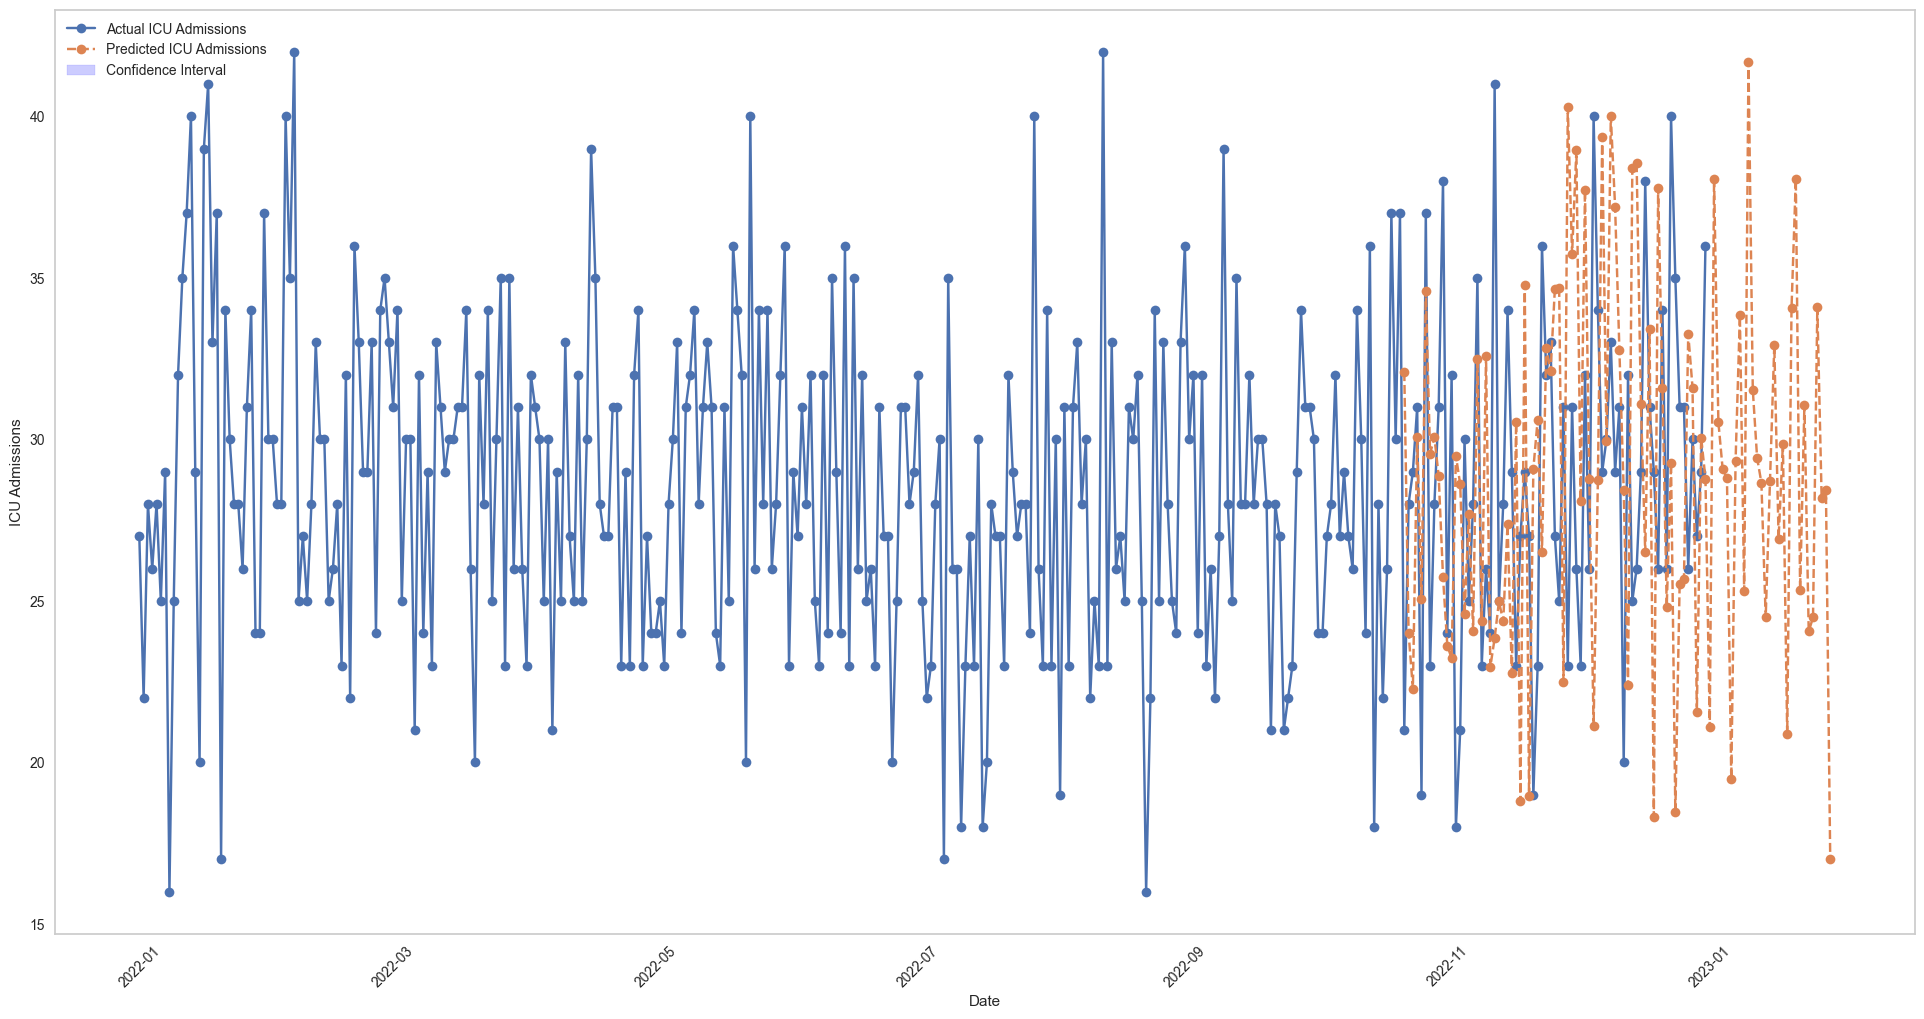

In [9]:
plt.figure(figsize=(24, 12))
plt.plot(df_daily.index, df_daily['ICU_Admissions'], label='Actual ICU Admissions', color='#4C72B0', marker='o')

plt.plot(future_predictions.index, future_predictions['y_pred'], label='Predicted ICU Admissions', color='#DD8452', linestyle='dashed', marker='o')

plt.fill_between(
    future_predictions.index,
    future_predictions['lower'],
    future_predictions['upper'],
    color='blue',
    alpha=0.2,
    label='Confidence Interval'
)
plt.xlabel('Date')
plt.ylabel('ICU Admissions')
# plt.title
plt.legend()
plt.xticks(rotation=45)
plt.grid()

plt.show()

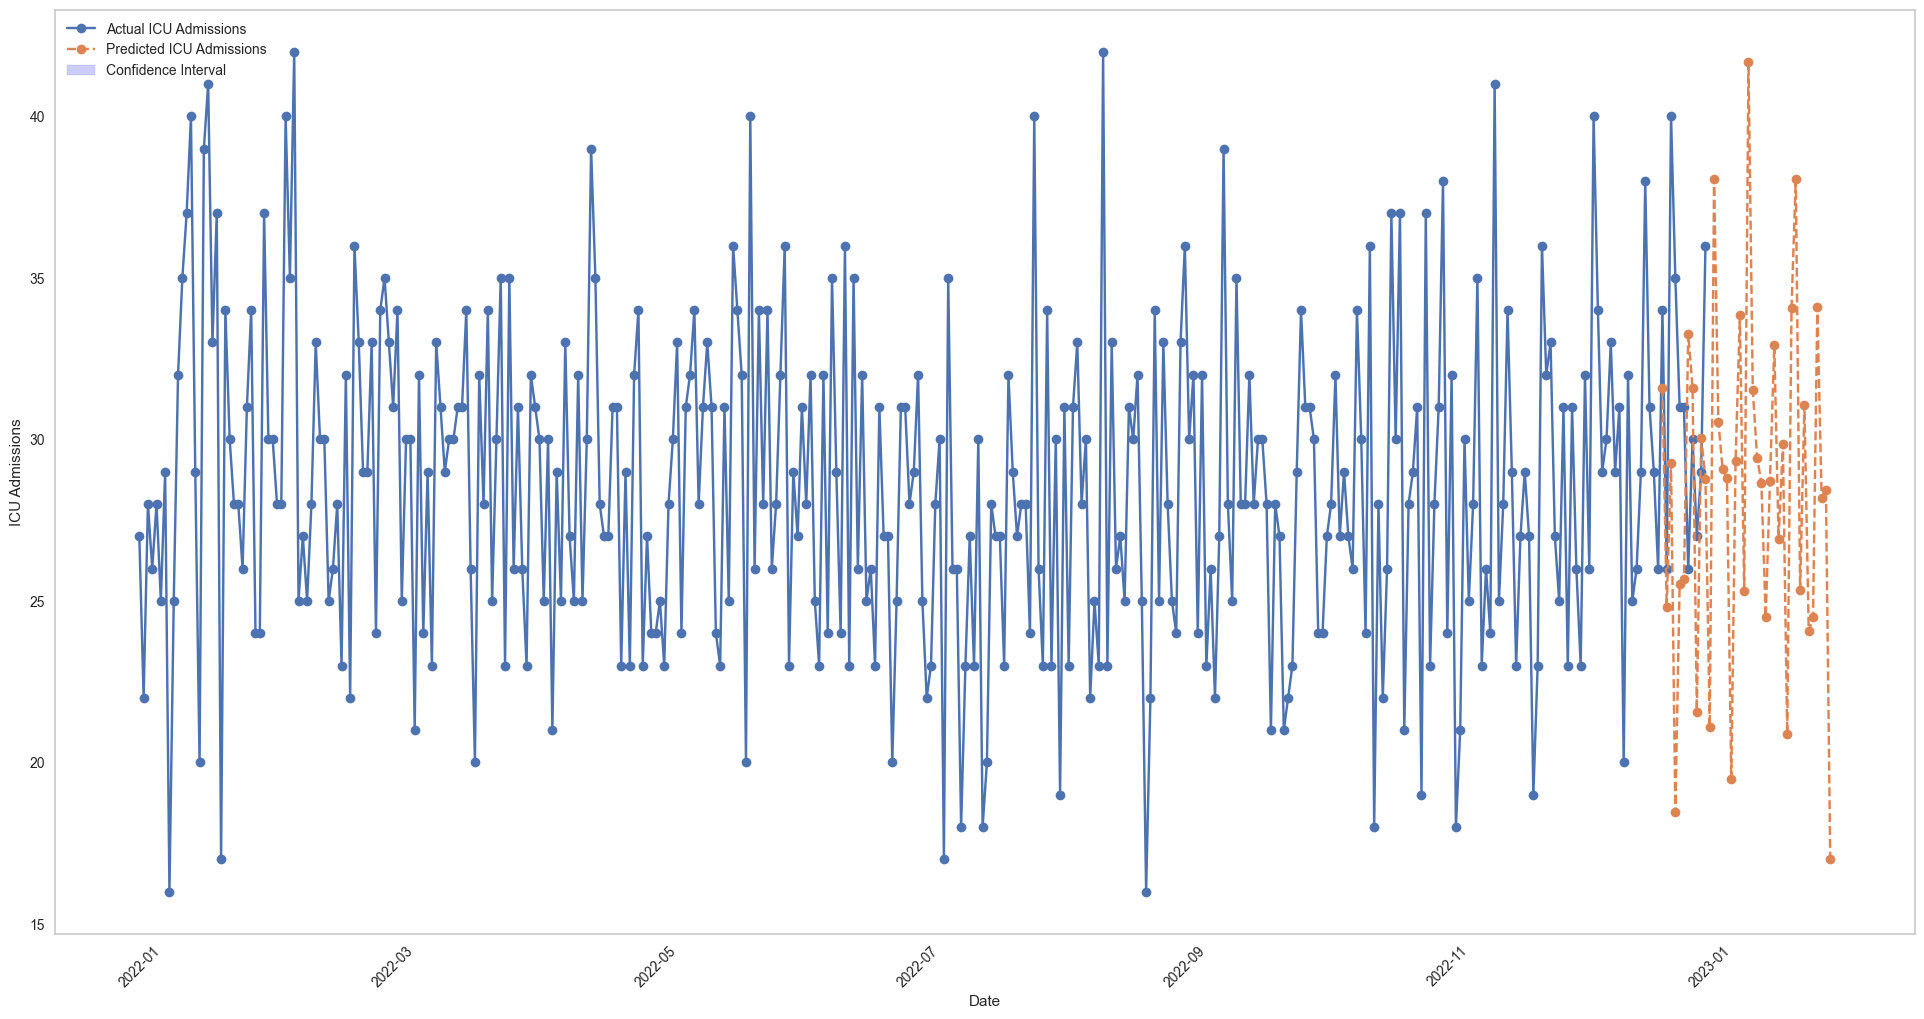

In [10]:
plt.figure(figsize=(24, 12))

# Plot only the last 100 points from actual ICU admissions
plt.plot(
    df_daily.index,  # Last 100 dates
    df_daily['ICU_Admissions'],  
    label='Actual ICU Admissions', 
    color='#4C72B0', 
    marker='o'
)

# Plot only the last 40 points from predicted ICU admissions
plt.plot(
    future_predictions.index[-40:],  # Last 40 forecasted dates
    future_predictions['y_pred'].iloc[-40:],  
    label='Predicted ICU Admissions', 
    color='#DD8452', 
    linestyle='dashed', 
    marker='o'
)

# Plot confidence interval for last 40 predictions
plt.fill_between(
    future_predictions.index[-40:],  
    future_predictions['lower'].iloc[-40:],  
    future_predictions['upper'].iloc[-40:],  
    color='blue', 
    alpha=0.2, 
    label='Confidence Interval'
)

# Labels, legend, and formatting
plt.xlabel('Date')
plt.ylabel('ICU Admissions')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


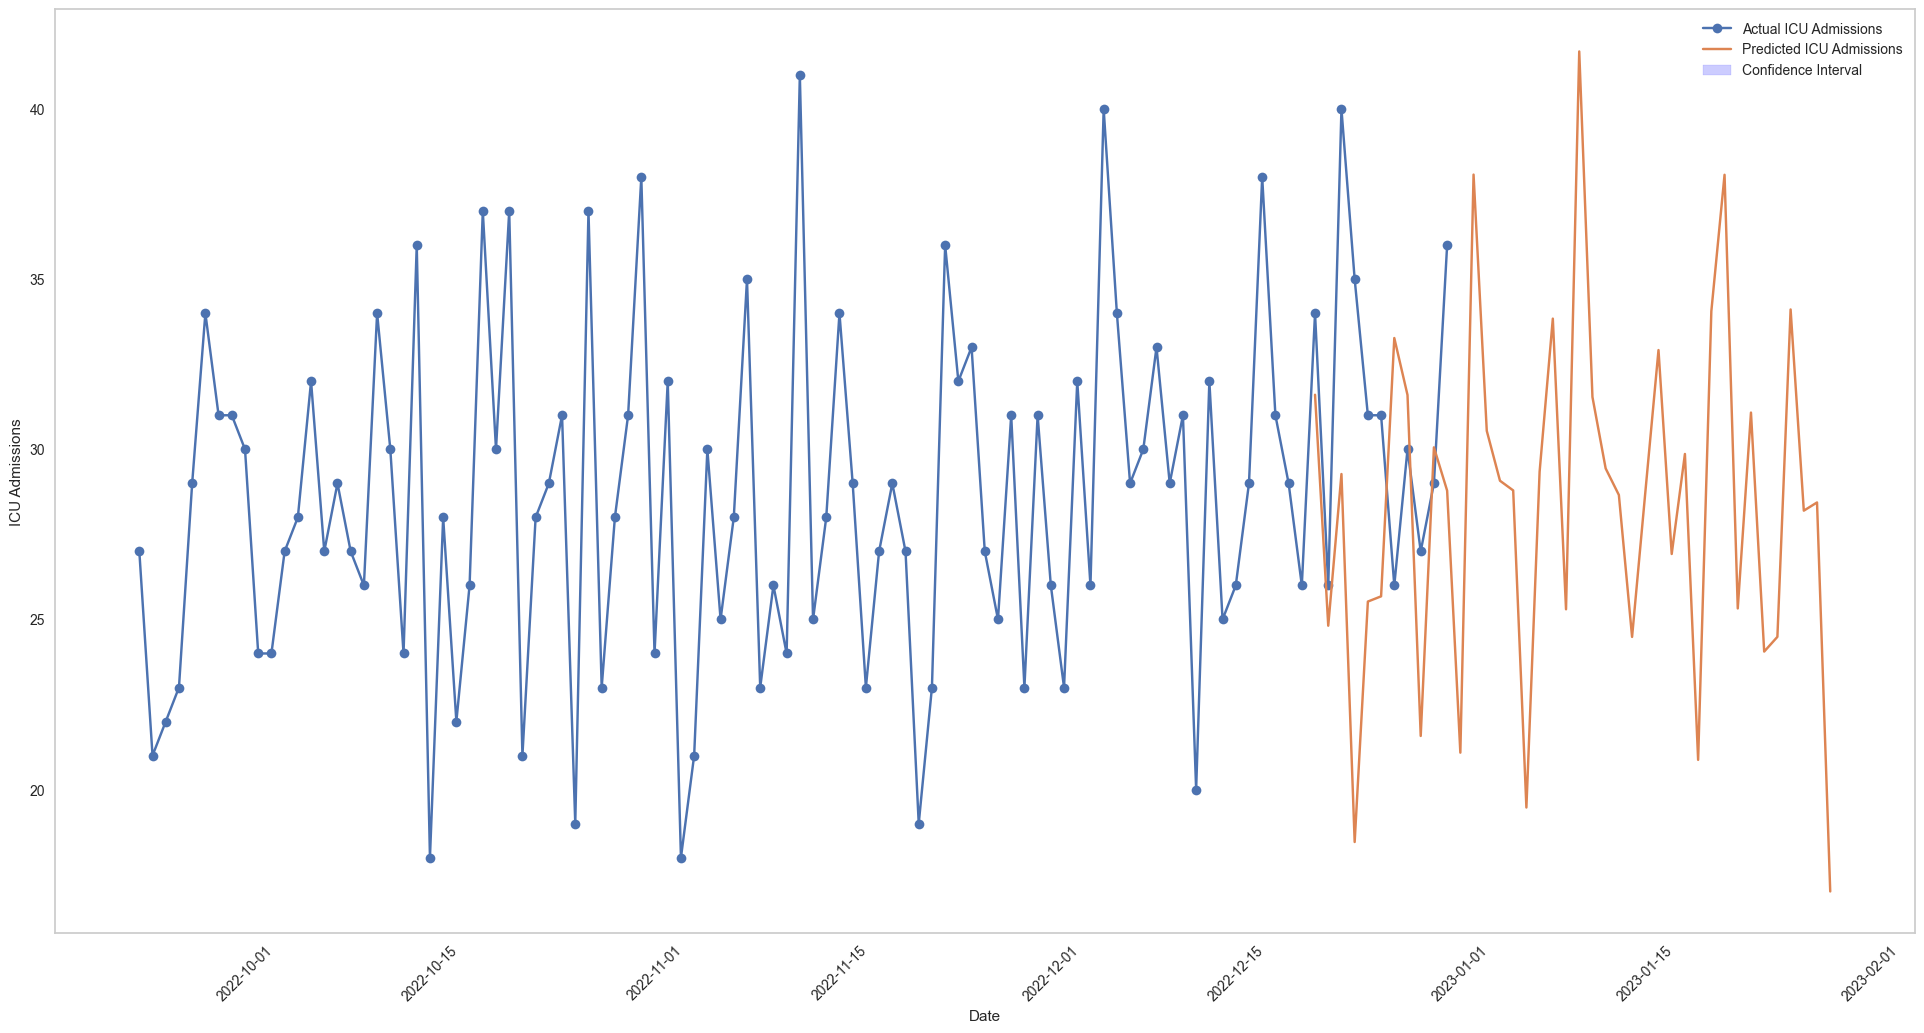

In [11]:
plt.figure(figsize=(24, 12))

# Plot only the last 100 points from actual ICU admissions
plt.plot(
    df_daily.index[-100:],  
    df_daily['ICU_Admissions'].iloc[-100:],  
    label='Actual ICU Admissions', 
    color='#4C72B0', 
    marker='o'  # Circle markers for actual values
)

# Plot only the last 40 points from predicted ICU admissions with 'x' markers
plt.plot(
    future_predictions.index[-40:],  
    future_predictions['y_pred'].iloc[-40:],  
    label='Predicted ICU Admissions', 
    color='#DD8452', 
    marker='x'  # 'X' markers for predicted values
)

# Plot confidence interval for last 40 predictions
plt.fill_between(
    future_predictions.index[-40:],  
    future_predictions['lower'].iloc[-40:],  
    future_predictions['upper'].iloc[-40:],  
    color='blue', 
    alpha=0.2, 
    label='Confidence Interval'
)

# Labels, legend, and formatting
plt.xlabel('Date')
plt.ylabel('ICU Admissions')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
